# Contact Invariant Optimization

This notebook gives an overview of [Contact Invariant Optimization](<https://homes.cs.washington.edu/~todorov/papers/MordatchSCA12.pdf>) (CIO) and an implementation of the method.

Solving for manipulation trajectories involving contact is a notoriously difficult optimization problem due to discontinuities introduced by the hybrid space. CIO attempts to solve this issue by smoothing the transitions between contact dynamics and free space dynamics.

CIO tries to solve the problem of finding a trajectory which manipulates an object into a desired state. The basis of CIO is the objective function which constrains the desired motion of the manipulated object and the manipulator. CIO attempts to solve for the necessary places to make contact, the forces to apply at these contact points, and the trajectory of the manipulated object and fingers. The paper describes all of the constraints used in the final optimization (L-BFGS). Here is a video of the kinds of manipulation plans CIO is able to find.

In [5]:
from IPython.lib.display import YouTubeVideo
YouTubeVideo('Gzt2UoxYfAQ')

# State

The manipulated object is a Circle with a position, $p_O$, and linear velocity $\dot{p}_O$. These make up the state variable for the object, $s_O = [p_O, \dot{p}_O]$.

In [6]:
from world import Circle, Position
"""
Position Attributes
-----
x : float
    x position
y : float
    y position

LinearVelocity Attributes
-----
x : float
    linear velocity in x direction
y : float
    linear velocity in y direction

Circle Parameters
------
radius : float
    the radius of the Circle
pos : Position
    the position of the Circle
vel : LinearVelocity, optional
    the linear velocity of the Circle, default = LinearVelocity(x=0.0, y=0.0)
"""
radius = 5.0
manip_obj = Circle(radius, Position(5.0,radius))

The manipulator is represented as a list of $N$ fingers. For finger $j$, the position is $p_j$ and the linear velocity is $\dot{p}_j$. These make up the hand state variable, $s_H = [p_j \dot{p}_j]$, $j \in \{1,...,N\}$

In [7]:
finger0 = Circle(1.0, Position(-5.0, -5.0))
finger1 = Circle(1.0, Position(15.0, -5.0))

The contact state for each finger is defined as follows. $f_j$ is the force applied by finger $j$. $r_j^O$ is a position in the object frame which describes where $f_j$ is originating. $r_j$ is $r_j^O$ in the world frame. $c_j \in [0,1]$ describes the nature of the contact. When $c_j = 1$, the finger should be in contact with the object, and when $c_j = 0$ it is not in contact. The figure below gives a visual for the contact parameters. These make up the contact state variable, $s_{CS} = [f_j, r_j^O c_j]$, $j \in \{1,...,N\}$. In the current implementation we use only positions instead of full poses. The $x$ variables in the image below are full poses.
![CIO State](notebook_files/contact_state.png)

In [8]:
from world import Contact
from collections import OrderedDict
"""
Contact Attributes
-----
f : tuple[2]
    x and y force
ro : tuple[2]
    position of applied force in the frame of the manipulated object
c : float in [0,1]
    the probability of being in contact
"""
contact_state = OrderedDict([(finger0, Contact(f=(0.0, 0.0), ro=(-7., -7.), c=.5)),
                             (finger1, Contact(f=(0.0, 0.0), ro=(7., -7.), c=.5))])

The entire state is:

$s = [s_O, s_H, s_{CS}]$

The objective is to get the manipulated object to a specific Position.

In [9]:
goals = [Position(5.0, 20.0)]

The world is then initialized from this initial state.

In [10]:
from world import World
"""
World Attributes (set with the following call)
-----
manip_obj : Circle
    the manipulated object
fingers : list of Circle
    a list of Circle objects representing fingers
contact_state : OrderedDict[Circle:Contact]
    a dictionary describing the contact state for each finger
"""
world = World(manip_obj, [finger0, finger1], contact_state)

# Trajectory

A trajectory is represented using $K$ keyframe states. $s_0$ is constrained the be the initial state, making the decision variables that are optimized over:
$S = [s_k], k \in [1,K]$

The decision variables are initialized to all correspond to the initial state of te system, with some added Gaussian noise.

During the optimization we interpolate between these keyframes to get a smooth trajectory, $s(t)$. Then this smoothed trajectory is used to calculate the cost of the objective function. Different interpolation methods are used for different parts of the state. The positions and velocities use cubic spline interpolation, the forces and $r$ values use linear interpolation, and the contact variables are piece-wise constant.

Run the following two cell to generate a .gif which will visualize the initial interpolated trajectory (thanks Tom!!).

Wrote out to initial.gif.
TRAJECTORY COSTS:
     CI:              37.239363383109406
     kinematics:      0.0
     physics:         3.0512480067145993
     task:            226.79476026674368
  TOTAL:  267.0853716565677


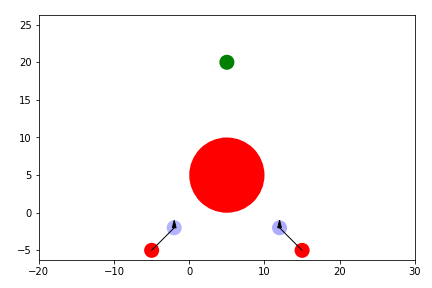

In [11]:
from params import Params
from CIO import CIO
import IPython

p = Params(world) # will discuss the params later, for now use default values

# the single argument just generates the trajectory, visualization, and calculates the cost
CIO(goals, world, p, single=True) 

# run the .gif
with open('initial.gif','rb') as f:
    display(IPython.display.Image(data=f.read(), format='png'))

The small red circles are the fingers and the large red circle is the manipulated object. The green circle is the goal position. The black line segments are from finger $j$ to the corresponding $r_j$, and the black arrow from $r_j$ is the applied force of contact $j$. The blue circles are the $r_j$ variables, and the shading represents the $c_j$ value (darker blue is $c_j$ closer to 1).

# Objective Cost Terms

The objective function is a weighted sum over different objective functions which are each summed over all states, $s(t)$.

## Contact-Invariant Cose: $L_{CI}(s_t)$

A contact $j$ is active when $c_j$ is close to 1. When this is true, the corresponding gripper must be constrained to be in contact with the object. To calculate this we introduce new variables, $\pi_O(r_j)$ and $\pi_j(r_j)$. $\pi_O(r_j)$ is $r_j$ projected onto finger $j$. $\pi_j(r_j)$ is $r_j$ projected onto the manipulated object. This objective term aims to minimize the distance between these projections and $r_j$ when $c_j$ is close to 1. They also aim to minimize the rate at which these distances change to dicourage slipping.
<img src="notebook_files/cis_cost.png" width="440" height="440" align="center"/>

Below is a visualization of a CIO solution which only has $L_{CI}(s)$ as the objective function and $K=10$.
![ci_gif](notebook_files/L_ci_vis.gif)

## Task Cost: $L_{task}(s_t)$

This is the constraint which defines the task goal. First $T_b$ is defined as the time region in which you want the goal enforced. Then $h_b(s)$ is the component of the state which you are driving to drive to the goal, and $h^{star}_{b,t}$ is the desired value of the state components extracted from $h_b(s)$. It simply states that we want to minimize the distance between the desired and final state at some specified time step

This term also regularizes the accelerations of the fingers and the object to encourage smoother trajectories. This regularization is parameterized by $\lambda$.

<img src="notebook_files/task_cost.png" width="440" height="440" align="center"/>

In the current implementation $h_b(s)$ can either be a desired Position or desired Velocity (this option hasn't been tested) of the object, and $T_b$ is just the final time step in the trajectory.

Below is a visualization of a CIO solution which only has $L_{task}(s)$ as the objective function with $K=10$ and $\lambda=10^{-3}$.
![task_gif](notebook_files/L_task_vis.gif)

## Physics Violation Cost: $L_{physics}(s_t)$

The physics constraint accounts for the fact that forces and moments on the object from the contacts must balance with any change in linear or angular momentum of the object. This term also includes a regularization on the contact forces to keep them small, parameterized by the same $\lambda$ as before. $f_{ext}$ and $m_{ext}$ in the equation below account for any external forces or moments such as those due to gravity.

<img src="notebook_files/phys_cost.png" width="440" height="440" align="center"/>

This term also has a friction cone component. For a coefficient of friction, $\mu$, the contact force $j$ should lie within a friction cone centered at the line between finger $j$ and $r_j$. This friction cone is centered around the black line shown in the visualizations.

<img src="notebook_files/cone_cost.png" width="440" height="440" align="center"/>

In the current implementation, gravity and angular moment conservation are not incorporated.

Below is a visualization of a CIO solution which only has $L_{task}(s)$ and $L_{physics}(s)$ as the objective function and $\lambda=10^{-3}$,  $\mu=0.9$. The decision variables were initialized to the values shown in the previous .gif (with the $L_{task}$ cost). If there were only a physics cost then the object would not move.

![phys_gif](notebook_files/L_task_phys_vis.gif)

## Kinematic Violation: $L_{kinematics}(s_t)$

This objective tries to minimize any violations of kinematic constraints, such as joint angles, the distance the fingers can extend from the hand, and collisions between any objects. None of these are implemented in this version. While this permits objects to collide, there is still an objective of making contact between the surfaces of fingers and objects due to the $L_{CI}(s)$ cost term.

## Total Objective Function

All of these terms are used in the final objective function which sums over time and each individual cost term.

<img src="notebook_files/final_cost.png" width="240" height="240" align="center"/>

# Optimization

CIO makes use of the L-BFGS optimization method and occurs over 2 calls to L-BFGS. The decision variables for the second call are initialized to the resulting values from the first optimization. In each phase the optimization functions are weighted differently. The first phase uses the following weights.

<img src="notebook_files/phase_0_weights.png" width="540" height="540" align="center"/>

The second phase uses the following weights.

<img src="notebook_files/phase_1_weights.png" width="540" height="540" align="center"/>

Now you can test it yourself with the following call, and play the resulting .gifs.

Wrote out to initial.gif.
TRAJECTORY COSTS:
     CI:              38.490886746897885
     kinematics:      0.0
     physics:         6.66788094751339
     task:            228.70486730541134
  TOTAL:  273.86363499982264
BEGINNING PHASE: 0
PHASE PARAMETERS:
     w_CI: 0.1
     w_kinematics: 0.0
     w_physics: 0.1
     w_task: 1.0
     lambda: 0.01
Wrote out to phase_0.gif.
TRAJECTORY COSTS:
     CI:              45.32088798265705
     kinematics:      0.0
     physics:         4.842432453445622
     task:            103.88624257957025
  TOTAL:  154.04956301567293
BEGINNING PHASE: 1
PHASE PARAMETERS:
     w_CI: 10.0
     w_kinematics: 0.0
     w_physics: 1.0
     w_task: 10.0
     lambda: 0.01
Wrote out to phase_1.gif.
TRAJECTORY COSTS:
     CI:              3116.6338733093194
     kinematics:      0.0
     physics:         31.394412452838644
     task:            1402.9017232637573
  TOTAL:  4550.930009025915


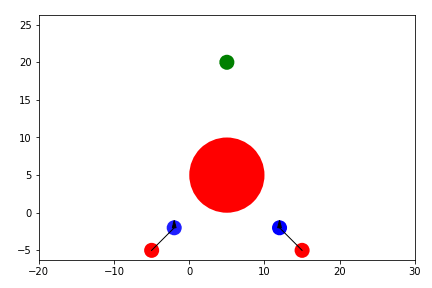

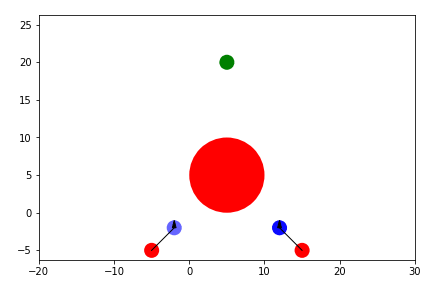

In [17]:
CIO(goals, world, p)
with open('phase_0.gif','rb') as f:
    display(IPython.display.Image(data=f.read(), format='png'))
with open('phase_1.gif','rb') as f:
    display(IPython.display.Image(data=f.read(), format='png'))

# Parameters

There are many parameters which can give very different optimization results. The Params() object which was initialized previously can take in arguments to override the default values. Below are the parameters used to initialize a Params() object initialized with their default values. Feel free to directly change them here.

In [18]:
"""
PhaseWeights Attributes
----------
w_CI : float
    the weight for the L_CI function
w_physics : float
    the weight for the L_physics function
w_kinematics : float
    the weight for the L_kinematics function (this parameter doesn't affect anything)
w_task : float
    the weight for the L_task function

Params Parameters
----------
world : world.World
    an object representing the objects in the world
K : int, optional
    the number of keyframes used to represent the trajectory
delT : float, optional
    the time step used to calculate derivates using finite differences
delT_keyframe : float, optional
    the length of time a keyframe lasts
mass : float, optional
    the mass (kg) of the manipulated object
mu : float, optional
    the coefficient of friction
lamb : float, optional
    a regularizer that keeps accelerations and applied forces small
phase_weights : list of PhaseWeights, optional
    the list of weights used during each optimization phase. the length of this list represents the number of optimization phases

Below are the deault values for all of the parameters
"""
from params import PhaseWeights
phase_weights=[PhaseWeights(w_CI=0.1, w_physics=0.1, w_kinematics=0.0, w_task=1.0),
                PhaseWeights(w_CI=10., w_physics=1., w_kinematics=0., w_task=10.)]
p = Params(world, K=2, delT=.1, delT_keyframe=0.5, mass=1., mu=0.9, lamb=10.e-3, phase_weights=phase_weights)
CIO(goals, world, p);

Wrote out to initial.gif.
TRAJECTORY COSTS:
     CI:              38.853255318590165
     kinematics:      0.0
     physics:         4.176970082127482
     task:            225.20173628938088
  TOTAL:  268.2319616900985
BEGINNING PHASE: 0
PHASE PARAMETERS:
     w_CI: 0.1
     w_kinematics: 0.0
     w_physics: 0.1
     w_task: 1.0
     lambda: 0.01
Wrote out to phase_0.gif.
TRAJECTORY COSTS:
     CI:              45.92653982880153
     kinematics:      0.0
     physics:         4.745021648763217
     task:            103.70445133335723
  TOTAL:  154.37601281092196
BEGINNING PHASE: 1
PHASE PARAMETERS:
     w_CI: 10.0
     w_kinematics: 0.0
     w_physics: 1.0
     w_task: 10.0
     lambda: 0.01
Wrote out to phase_1.gif.
TRAJECTORY COSTS:
     CI:              3118.9486729514206
     kinematics:      0.0
     physics:         29.135153427161335
     task:            1396.0202887272044
  TOTAL:  4544.104115105786


# Your Testing

Now feel free to play around with CIO. Here are some ideas for the adventurous:
- Change the initial world state 
    - Where the objects are
    - The contact state values
    - The number of fingers
- Change the parameters
    - Different phase weights
    - Different number of phases
    - Different coefficient of friction
- Change the goal description
    - The goals parameter passed into CIO() is a list of constraints on the world state. Currently it can only take in a constraint on the Position and LinearVelocity of the manipulated object at the final time step, but it isn't too difficult to add more goal types.
    - Try sequential goals
    - Try constraining the goal velocity
- Change other parts of the cost function
    - Try to add gravity
    
The cost functions are all in CIO.py and named the same as above. They take in a time, t, and the world state at time t. See world.World() for what can be accessed in a world state.
        